In [1]:
import os
import json
import pyproj
import numpy as np
import pandas as pd
from tqdm import tqdm
from pyproj import Geod
import matplotlib.pyplot as plt

In [2]:
TRAINS_DATA_V3_PATH = "../../data/processed/trains_v3.parquet"

trains = pd.read_parquet(TRAINS_DATA_V3_PATH)
trains.head()

,trip_id,product_id,line_text,transport_type,stop_id,arrival_time,departure_time,mean_arrival_delay,mean_departure_delay,median_arrival_delay,...,std_arrival_delay,std_departure_delay,n_arrival_delay,n_departure_delay,n_cancelled,n_through_trip,n_additional_trip,n_entries,time,trip_index
0,80:800693:3040:000_1,Train,IRE3,IRE,8500090,08:15:00,None,126.575342,NaN,0.0,...,437.328440,NaN,17,0,2,0,0,76,08:15:00,1
1,80:800693:3040:000_2,Train,IRE3,IRE,8500090,09:15:00,None,63.750000,NaN,0.0,...,341.497883,NaN,22,0,4,0,0,148,09:15:00,1
2,80:800693:3040:000_1,Train,IRE3,IRE,8503424,06:58:00,07:00:00,307.000000,252.146667,101.0,...,644.312728,638.846885,75,75,1,0,0,76,06:58:00,0
3,80:800693:3040:000_2,Train,IRE3,IRE,8503424,07:58:00,08:00:00,158.090278,114.597222,92.0,...,356.211415,351.588390,142,144,4,0,0,148,07:58:00,0
4,80:800693:3041:000_1,Train,RB,RB,8500090,None,05:58:00,NaN,NaN,NaN,...,NaN,NaN,0,0,2,0,0,80,05:58:00,0


In [3]:
trains = trains[['trip_id', 'stop_id', 'time', 'line_text', 'mean_arrival_delay', 'mean_departure_delay']]
trains = trains.rename(columns={
    'mean_arrival_delay': 'arrival_delay',
    'mean_departure_delay': 'departure_delay'
    })

trains.head()

,trip_id,stop_id,time,line_text,arrival_delay,departure_delay
0,80:800693:3040:000_1,8500090,08:15:00,IRE3,126.575342,NaN
1,80:800693:3040:000_2,8500090,09:15:00,IRE3,63.750000,NaN
2,80:800693:3040:000_1,8503424,06:58:00,IRE3,307.000000,252.146667
3,80:800693:3040:000_2,8503424,07:58:00,IRE3,158.090278,114.597222
4,80:800693:3041:000_1,8500090,05:58:00,RB,NaN,NaN


In [4]:
trains.shape

(346929, 6)

In [5]:
# Sort by trip_id and time
trains.sort_values(by=['trip_id', 'time'], inplace=True)

# Add the end_stop_id and end_time to each valid row
trains[['end_stop_id', 'end_time', 'end_arrival_delay', 'end_departure_delay']] = trains.groupby('trip_id')[['stop_id', 'time', 'arrival_delay', 'departure_delay']].shift(-1)
trains = trains[trains['end_stop_id'].notna()]
trains = trains[trains['end_time'].notna()]


# Rename columns
trains = trains.rename(columns={
    'stop_id': 'start_stop_id', 
    'time': 'start_time',
    'arrival_delay': 'start_arrival_delay',
    'departure_delay': 'start_departure_delay'
})

trains.drop(columns=['start_arrival_delay', 'end_departure_delay'], inplace=True)

trains.head()

,trip_id,start_stop_id,start_time,line_text,start_departure_delay,end_stop_id,end_time,end_arrival_delay
2,80:800693:3040:000_1,8503424,06:58:00,IRE3,252.146667,8500090.0,08:15:00,126.575342
3,80:800693:3040:000_2,8503424,07:58:00,IRE3,114.597222,8500090.0,09:15:00,63.750000
4,80:800693:3041:000_1,8500090,05:58:00,RB,NaN,8503424.0,07:27:00,114.069767
5,80:800693:3041:000_2,8500090,06:58:00,RB,NaN,8503424.0,08:27:00,132.069930
10,80:800693:3042:000_1,8503424,07:58:00,IRE,95.884615,8500090.0,09:12:00,49.459459


In [6]:
# Read stops data
STOPS_PATH = "../../data/processed/stops.csv"

stops = pd.read_csv(STOPS_PATH)
stops = stops[['stop_id', 'stop_lon', 'stop_lat']]
stops.head()

,stop_id,stop_lon,stop_lat
0,8500010,2611363.0,1266310.0
1,8500016,2610076.0,1268853.0
2,8500020,2615758.0,1264783.0
3,8500021,2618994.0,1263578.0
4,8500023,2622064.0,1259341.0


In [7]:
# Map (CH1903 / LV03) coordinates to (WGS84) coordinates
# Define the source (CH1903 / LV03) and target (WGS84) coordinate systems
source_crs = pyproj.CRS("EPSG:2056")  # Swiss Coordinate System (CH1903 / LV03)
target_crs = pyproj.CRS("EPSG:4326")   # WGS84 (latitude and longitude)

# Define the transformer
transformer = pyproj.Transformer.from_crs(source_crs, target_crs)

# Convert the coordinates
# Inverse both because the source coordinates are in (y, x) order
stops['stop_lat'], stops['stop_lon'] = transformer.transform(stops['stop_lon'].to_list(), stops['stop_lat'].to_list())

# Check the transformed coordinates
stops.head()

,stop_id,stop_lon,stop_lat
0,8500010,7.589564,47.547414
1,8500016,7.572525,47.570305
2,8500020,7.647892,47.533590
3,8500021,7.690815,47.522667
4,8500023,7.731367,47.484465


In [8]:
# Add latitude and longitude informations
trains = pd.merge(trains, stops, left_on='start_stop_id', right_on='stop_id')
trains = trains.rename(columns={
    'stop_lon': 'start_stop_lon',
    'stop_lat': 'start_stop_lat'
})

trains = pd.merge(trains, stops, left_on='end_stop_id', right_on='stop_id')
trains = trains.rename(columns={
    'stop_lon': 'end_stop_lon',
    'stop_lat': 'end_stop_lat'
})

# Remove stop_ids
trains = trains.drop(columns=['start_stop_id', 'end_stop_id'])

trains.head()

,trip_id,start_time,line_text,start_departure_delay,end_time,end_arrival_delay,stop_id_x,start_stop_lon,start_stop_lat,stop_id_y,end_stop_lon,end_stop_lat
0,80:800693:3040:000_1,06:58:00,IRE3,252.146667,08:15:00,126.575342,8503424,8.632755,47.698282,8500090,7.606922,47.567311
1,80:800693:3040:000_2,07:58:00,IRE3,114.597222,09:15:00,63.750000,8503424,8.632755,47.698282,8500090,7.606922,47.567311
2,80:800693:3042:000_1,07:58:00,IRE,95.884615,09:12:00,49.459459,8503424,8.632755,47.698282,8500090,7.606922,47.567311
3,80:800693:3042:000_2,08:58:00,IRE3,108.889655,10:12:00,66.206897,8503424,8.632755,47.698282,8500090,7.606922,47.567311
4,80:800693:3044:000_1,08:58:00,IRE,178.807692,10:12:00,41.538462,8503424,8.632755,47.698282,8500090,7.606922,47.567311


In [9]:
# Change time to number of minutes since midnight
trains['start_time'] = trains['start_time'].astype('datetime64[ns]')
trains['end_time'] = trains['end_time'].astype('datetime64[ns]')

trains['start_time'] = trains['start_time'].apply(lambda x: x.hour * 60 + x.minute)
trains['end_time'] = trains['end_time'].apply(lambda x: x.hour * 60 + x.minute)

trains.head()

,trip_id,start_time,line_text,start_departure_delay,end_time,end_arrival_delay,stop_id_x,start_stop_lon,start_stop_lat,stop_id_y,end_stop_lon,end_stop_lat
0,80:800693:3040:000_1,418,IRE3,252.146667,495,126.575342,8503424,8.632755,47.698282,8500090,7.606922,47.567311
1,80:800693:3040:000_2,478,IRE3,114.597222,555,63.750000,8503424,8.632755,47.698282,8500090,7.606922,47.567311
2,80:800693:3042:000_1,478,IRE,95.884615,552,49.459459,8503424,8.632755,47.698282,8500090,7.606922,47.567311
3,80:800693:3042:000_2,538,IRE3,108.889655,612,66.206897,8503424,8.632755,47.698282,8500090,7.606922,47.567311
4,80:800693:3044:000_1,538,IRE,178.807692,612,41.538462,8503424,8.632755,47.698282,8500090,7.606922,47.567311


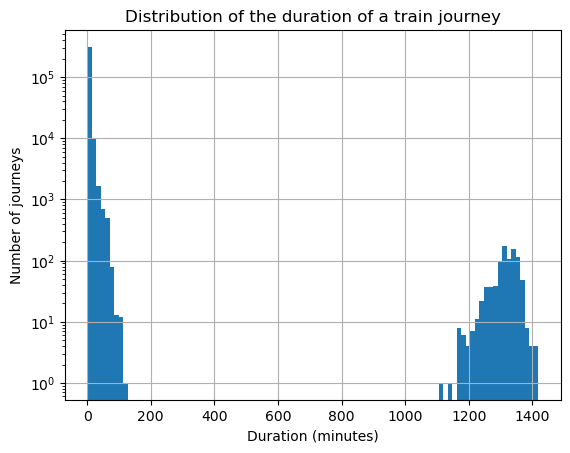

In [10]:
# Filter out trains that seem too slow
# This might happen for trains thatstart at 23:59 and end at 00:01 for example

trains['dt'] = trains['end_time'] - trains['start_time']
trains.hist(column='dt', bins=100, log=True)
plt.title('Distribution of the duration of a train journey')
plt.xlabel('Duration (minutes)')
plt.ylabel('Number of journeys')
plt.show()

In [11]:
TIME_THD = 800

trains_to_fix = trains[trains['dt'] > TIME_THD]
trains = trains[trains['dt'] < TIME_THD]
trains_to_fix.head()

,trip_id,start_time,line_text,start_departure_delay,end_time,end_arrival_delay,stop_id_x,start_stop_lon,start_stop_lat,stop_id_y,end_stop_lon,end_stop_lat,dt
31,80:800693:3077:000_1,16,RB,94.573034,1372,NaN,8503424,8.632755,47.698282,8500090,7.606922,47.567311,1356
32,80:800693:3077:000_2,76,RB,221.945578,1432,NaN,8503424,8.632755,47.698282,8500090,7.606922,47.567311,1356
44,85:11:1171:001_2,64,ICE,NaN,1432,1143.571429,8500010,7.589564,47.547414,8500090,7.606922,47.567311,1368
51,85:11:266:001_1,7,IC,NaN,1378,179.259259,8500010,7.589564,47.547414,8500090,7.606922,47.567311,1371
181,85:11:79:001_1,0,ICE,NaN,1306,1071.089109,8503000,8.540218,47.378177,8500090,7.606922,47.567311,1306


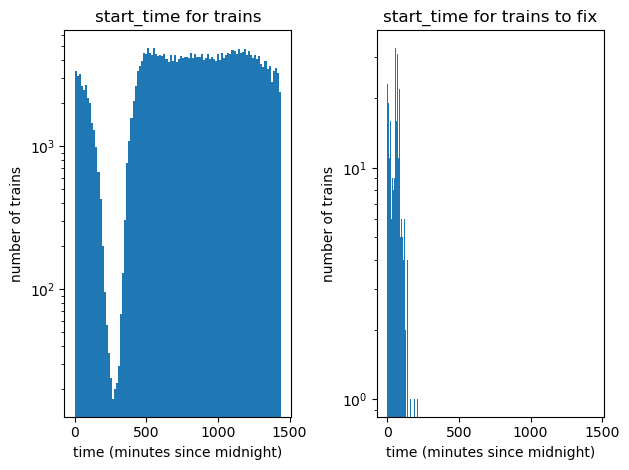

In [12]:
fig, axs = plt.subplots(1, 2, sharey=False, sharex=True, tight_layout=True)
axs[0].hist(trains['start_time'], bins=100, log=True)
axs[1].hist(trains_to_fix['start_time'], bins=100, log=True)
axs[0].set_title('start_time for trains')
axs[1].set_title('start_time for trains to fix')
axs[0].set_xlabel('time (minutes since midnight)')
axs[1].set_xlabel('time (minutes since midnight)')
axs[0].set_ylabel('number of trains')
axs[1].set_ylabel('number of trains')
plt.show()

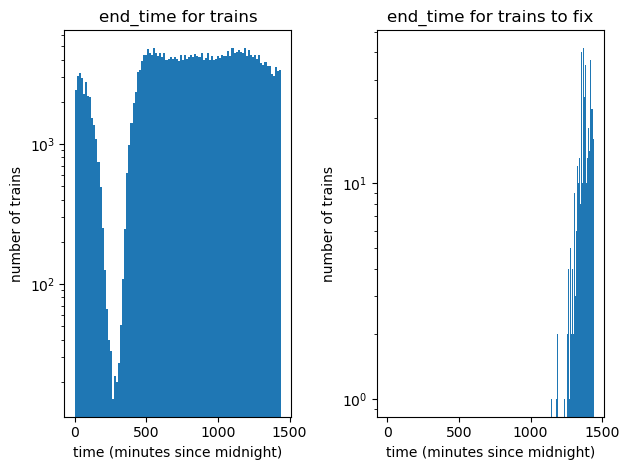

In [13]:
fig, axs = plt.subplots(1, 2, sharey=False, sharex=True, tight_layout=True)
axs[0].hist(trains['end_time'], bins=100, log=True)
axs[1].hist(trains_to_fix['end_time'], bins=100, log=True)
axs[0].set_title('end_time for trains')
axs[1].set_title('end_time for trains to fix')
axs[0].set_xlabel('time (minutes since midnight)')
axs[1].set_xlabel('time (minutes since midnight)')
axs[0].set_ylabel('number of trains')
axs[1].set_ylabel('number of trains')
plt.show()

The trains in the right cluster are trains that depart a given day, and arrive the next day. These trains must be split into two separate journeys, one for each day.

In [14]:
trains_to_fix_a = trains_to_fix.copy()
trains_to_fix_b = trains_to_fix.copy()

In [15]:
# Update coordinates because they are split into 2 separate trips.
trains_to_fix_a['midnight_checkpoint_ratio'] = (1440 - trains_to_fix_a['end_time']) / (1440 - trains_to_fix_a['dt'])
midnight_checkpoint_lon = trains_to_fix_a['start_stop_lon'] + trains_to_fix_a['midnight_checkpoint_ratio'] * (trains_to_fix_a['end_stop_lon'] - trains_to_fix_a['start_stop_lon'])
midnight_checkpoint_lat = trains_to_fix_a['start_stop_lat'] + trains_to_fix_a['midnight_checkpoint_ratio'] * (trains_to_fix_a['end_stop_lat'] - trains_to_fix_a['start_stop_lat'])
trains_to_fix_a['end_stop_lon'] = midnight_checkpoint_lon
trains_to_fix_a['end_stop_lat'] = midnight_checkpoint_lat
trains_to_fix_b['start_stop_lon'] = midnight_checkpoint_lon
trains_to_fix_b['start_stop_lat'] = midnight_checkpoint_lat

# Update times
trains_to_fix_a['start_time'] = trains_to_fix_a['end_time']
trains_to_fix_a['end_time'] = 24 * 60 - 1
trains_to_fix_b['end_time'] = trains_to_fix_b['start_time']
trains_to_fix_b['start_time'] = 0

# Remove cols
trains_to_fix_a = trains_to_fix_a.drop(columns=['midnight_checkpoint_ratio'])

In [16]:
trains_to_fix = pd.concat([trains_to_fix_a, trains_to_fix_b])
trains = pd.concat([trains, trains_to_fix])

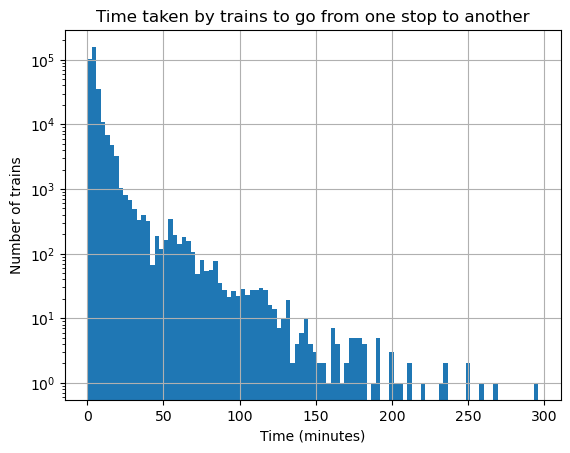

In [17]:
trains['dt'] = trains['end_time'] - trains['start_time']
trains.hist(column='dt', bins=100, log=True)
plt.title('Time taken by trains to go from one stop to another')
plt.xlabel('Time (minutes)')
plt.ylabel('Number of trains')
plt.show()

The time difference is much more coherent.

In [18]:
trains.head()

,trip_id,start_time,line_text,start_departure_delay,end_time,end_arrival_delay,stop_id_x,start_stop_lon,start_stop_lat,stop_id_y,end_stop_lon,end_stop_lat,dt
0,80:800693:3040:000_1,418,IRE3,252.146667,495,126.575342,8503424,8.632755,47.698282,8500090,7.606922,47.567311,77
1,80:800693:3040:000_2,478,IRE3,114.597222,555,63.750000,8503424,8.632755,47.698282,8500090,7.606922,47.567311,77
2,80:800693:3042:000_1,478,IRE,95.884615,552,49.459459,8503424,8.632755,47.698282,8500090,7.606922,47.567311,74
3,80:800693:3042:000_2,538,IRE3,108.889655,612,66.206897,8503424,8.632755,47.698282,8500090,7.606922,47.567311,74
4,80:800693:3044:000_1,538,IRE,178.807692,612,41.538462,8503424,8.632755,47.698282,8500090,7.606922,47.567311,74


In [19]:
geod = Geod(ellps='WGS84')

def calculate_distance(row):
    _, _, distance = geod.inv(row['start_stop_lon'], row['start_stop_lat'],
                              row['end_stop_lon'], row['end_stop_lat'])
    return distance

# Apply the function to the DataFrame
trains['distance'] = trains.apply(calculate_distance, axis=1)
trains['speed'] = trains['distance'] / (trains['dt'] * 60)
trains = trains[trains['dt'] != 0]

In [20]:
trains.head()

,trip_id,start_time,line_text,start_departure_delay,end_time,end_arrival_delay,stop_id_x,start_stop_lon,start_stop_lat,stop_id_y,end_stop_lon,end_stop_lat,dt,distance,speed
0,80:800693:3040:000_1,418,IRE3,252.146667,495,126.575342,8503424,8.632755,47.698282,8500090,7.606922,47.567311,77,78457.29586,16.982099
1,80:800693:3040:000_2,478,IRE3,114.597222,555,63.750000,8503424,8.632755,47.698282,8500090,7.606922,47.567311,77,78457.29586,16.982099
2,80:800693:3042:000_1,478,IRE,95.884615,552,49.459459,8503424,8.632755,47.698282,8500090,7.606922,47.567311,74,78457.29586,17.670562
3,80:800693:3042:000_2,538,IRE3,108.889655,612,66.206897,8503424,8.632755,47.698282,8500090,7.606922,47.567311,74,78457.29586,17.670562
4,80:800693:3044:000_1,538,IRE,178.807692,612,41.538462,8503424,8.632755,47.698282,8500090,7.606922,47.567311,74,78457.29586,17.670562


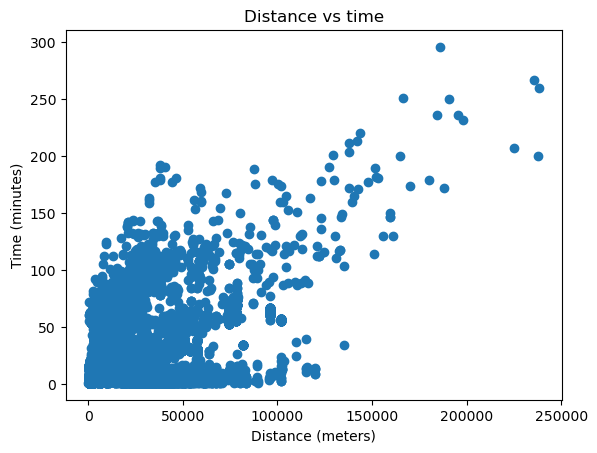

In [21]:
plt.scatter(trains['distance'], trains['dt'])
plt.title('Distance vs time')
plt.xlabel('Distance (meters)')
plt.ylabel('Time (minutes)')
plt.show()

In [22]:
trains['speed'].describe()

count    325441.000000
mean         14.267120
std          33.264460
min           0.058505
25%           8.040095
50%          11.440618
75%          15.477582
max        1494.818687
Name: speed, dtype: float64

In [23]:
# Remove all trains that are not in the 99% percentile
trains = trains[trains['speed'] < trains['speed'].quantile(0.99)]

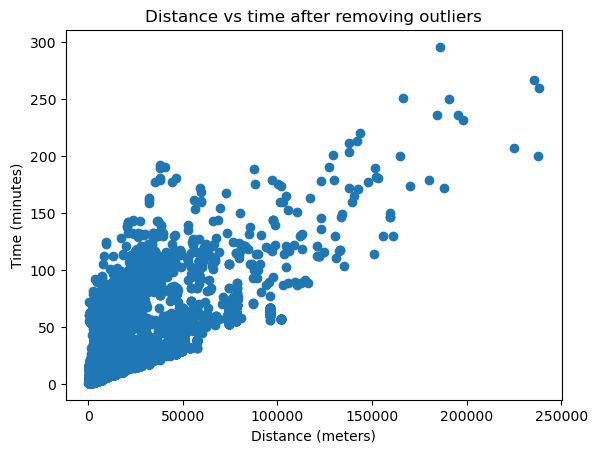

In [24]:
plt.scatter(trains['distance'], trains['dt'])
plt.title('Distance vs time after removing outliers')
plt.xlabel('Distance (meters)')
plt.ylabel('Time (minutes)')
plt.show()

In [25]:
BIN_SIZE = 15

# Compute bins where the train is present
trains['bins'] = trains.apply(lambda x: np.arange(x['start_time'] // BIN_SIZE, x['end_time'] // BIN_SIZE + 1), axis=1)
trains['bins'] = trains['bins'] * BIN_SIZE

# Add entry of train for every bin it is present
trains = trains.explode('bins')
trains = trains.rename(columns={
    'bins': 'bin'
})

trains.head()

,trip_id,start_time,line_text,start_departure_delay,end_time,end_arrival_delay,stop_id_x,start_stop_lon,start_stop_lat,stop_id_y,end_stop_lon,end_stop_lat,dt,distance,speed,bin
0,80:800693:3040:000_1,418,IRE3,252.146667,495,126.575342,8503424,8.632755,47.698282,8500090,7.606922,47.567311,77,78457.29586,16.982099,405
0,80:800693:3040:000_1,418,IRE3,252.146667,495,126.575342,8503424,8.632755,47.698282,8500090,7.606922,47.567311,77,78457.29586,16.982099,420
0,80:800693:3040:000_1,418,IRE3,252.146667,495,126.575342,8503424,8.632755,47.698282,8500090,7.606922,47.567311,77,78457.29586,16.982099,435
0,80:800693:3040:000_1,418,IRE3,252.146667,495,126.575342,8503424,8.632755,47.698282,8500090,7.606922,47.567311,77,78457.29586,16.982099,450
0,80:800693:3040:000_1,418,IRE3,252.146667,495,126.575342,8503424,8.632755,47.698282,8500090,7.606922,47.567311,77,78457.29586,16.982099,465


In [26]:
trains = trains.replace({np.nan: None})

In [27]:
data_trips = {}
for trip_id, group in tqdm(trains.groupby('trip_id')):
    data_trips[trip_id] = []
    for _, row in group.iterrows():
        data_trips[trip_id].append({
            'line_text': row['line_text'],
            'start_time': row['start_time'],
            'end_time': row['end_time'],
            'start_stop_lon': row['start_stop_lon'],
            'start_stop_lat': row['start_stop_lat'],
            'start_departure_delay': row['start_departure_delay'],
            'end_stop_lon': row['end_stop_lon'],
            'end_stop_lat': row['end_stop_lat'],
            'end_arrival_delay': row['end_arrival_delay'],
            'bin': row['bin']
        })

100%|██████████| 31887/31887 [00:18<00:00, 1770.87it/s]


In [28]:
def get_trip_in_bin(trip_id, bin):
    for trip in bin['trips']:
        if trip['trip_id'] == trip_id:
            return trip
    return None

In [29]:
data_bins = {}
for trip_id, trip_values in tqdm(data_trips.items()):
    for trip_value in trip_values:
        if str(trip_value['bin']) not in data_bins:
            data_bins[str(trip_value['bin'])] = {'trips': []}

        data_trip = get_trip_in_bin(trip_id, data_bins[str(trip_value['bin'])])
        if data_trip is None:
            data_bins[str(trip_value['bin'])]['trips'].append({
                'trip_id': trip_id,
                'segments' : []
            })
            data_trip = get_trip_in_bin(trip_id, data_bins[str(trip_value['bin'])])

        data_trip['segments'].append({
            'line_text': trip_value['line_text'],
            'start_time': trip_value['start_time'],
            'start_longitude': trip_value['start_stop_lon'],
            'start_latitude': trip_value['start_stop_lat'],
            'start_departure_delay': trip_value['start_departure_delay'],
            'end_time': trip_value['end_time'],
            'end_longitude': trip_value['end_stop_lon'],
            'end_latitude': trip_value['end_stop_lat'],
            'end_arrival_delay': trip_value['end_arrival_delay']
        })  

# sort every segment list by start_time
for bin in tqdm(data_bins.values()):
    for trip in bin['trips']:
        trip['segments'].sort(key=lambda x: x['start_time'])

100%|██████████| 96/96 [00:00<00:00, 769.51it/s]


In [30]:
data = {
    'bin_size' : BIN_SIZE,
    'bins' : data_bins
}

In [31]:
def handle_nan(obj):
    if isinstance(obj, float) and np.isnan(obj):
        return None
    raise TypeError

In [38]:
# write as json
TRAIN_TRIPS_BINS = f"../../data/processed/train_trips_bins_{BIN_SIZE}.json"
    
with open(TRAIN_TRIPS_BINS, 'w') as outfile:
    json.dump(data, outfile, indent=4, default=handle_nan)

## Split file into multiple bins

In [32]:
# Create train_trips_bins folder
TRAIN_TRIPS_BINS_FOLDER = f"../../data/processed/train_trips_bins"
if not os.path.exists(TRAIN_TRIPS_BINS_FOLDER):
    os.makedirs(TRAIN_TRIPS_BINS_FOLDER)

In [33]:
# Write every bin in a separate file
for bin_id, bin in tqdm(data_bins.items()):
    with open(f"{TRAIN_TRIPS_BINS_FOLDER}/{bin_id}.json", 'w') as outfile:
        json.dump(bin, outfile, indent=4, default=handle_nan)

100%|██████████| 96/96 [00:07<00:00, 12.16it/s]
